# Experimenting with the Direction of Partition

Federated learning literature on device heterogeneity has presented only a limited set of partition strategies for creating smaller
neural networks for less powerful devices. In this experiment, we explore in which direction the partitioning strategy has a greater
effect on computation time. We also explore the effect of the partitioning strategy on the accuracy of the model.

First, we will install the required packages, then import them into the notebook.

In [1]:
import math
import time
import matplotlib.pyplot as plt
import numpy as np
import pickle

import datasets
import jax
import jax.numpy as jnp
import optax
import einops
import flax.linen as nn
from tqdm.auto import trange

%matplotlib inline

/home/cody/.cache/pypoetry/virtualenvs/ppdhfl-UqOBZkB6-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


For these experiments, we will consider two types of networks: linear and convolutional. We will then compare the resulting average wall clock
time to compute a single step of training across different amounts of partitioning with respect to the partitioning types, width and height.
We define width partitioning as the reduction of hidden parameters in every layer by a factor of $p \in (0, 1]$, and height partitioning as the reduction
of number of layers by a factor of $p \in (0, 1]$.

We perform all experiments using the MNIST dataset, across ten partitioning factors.

In [2]:
def load_dataset():
    "Load the MNIST dataset"
    ds = datasets.load_dataset('mnist')
    ds = ds.map(
        lambda e: {
            'X': einops.rearrange(np.array(e['image'], dtype=np.float32) / 255, "h (w c) -> h w c", c=1),
            'Y': e['label']
        },
        remove_columns=['image', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(28, 28, 1), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return ds

ds = load_dataset()
X, y = np.concatenate((ds['train']['X'], ds['test']['X'])), np.concatenate((ds['train']['Y'], ds['test']['Y']))
train = np.concatenate((np.repeat(True, len(ds['train'])), np.repeat(False, len(ds['test']))))

All networks are trained with a SGD optimizer and a learning rate of 0.1. The loss function is cross entropy.

In each computation speed experiment we evaluate across 100 seeds, and we use the average of the results as the final result which we plot with respect
to the amount of partitioning. For our accuracy experiments, we evaluate the accuracy of the model after 3000 steps of training.

In [3]:
def ce_loss(model):
    def _loss(params, X, y):
        logits = jnp.clip(model.apply(params, X), 1e-15, 1 - 1e-15)
        one_hot = jax.nn.one_hot(y, logits.shape[-1])
        return -jnp.mean(jnp.einsum("bl,bl -> b", one_hot, jnp.log(logits)))
    return _loss

def trainer_fn(opt, loss):
    def _apply(params, opt_state, X, Y):
        loss_val, grads = jax.value_and_grad(loss)(params, X, Y)
        updates, opt_state = opt.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_val
    return _apply

def accuracy(model, params, X, Y):
    return jnp.mean(jnp.argmax(model.apply(params, X), axis=-1) == Y)

def save_data(filename, data):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Experiment functions

def speed_experiment(net_type, jit=True):
    max_p = 10
    train_len = len(X[train])
    results = {p / max_p: [] for p in range(1, max_p + 1)}
    for p in trange(1, max_p + 1):
        net = net_type(p / max_p, 10, 10)
        params = net.init(jax.random.PRNGKey(42), jnp.zeros_like(X[:128]))
        opt = optax.sgd(0.1)
        opt_state = opt.init(params)
        trainer = trainer_fn(opt, ce_loss(net))
        if jit:
            trainer = jax.jit(trainer)
            trainer(params, opt_state, X[:128], y[:128])
        rng = np.random.default_rng(0)
        for _ in range(1000):
            idx = rng.choice(train_len, 128, replace=False)
            start = time.perf_counter()
            trainer(params, opt_state, X[idx], y[idx])
            end = time.perf_counter()
            results[p / max_p].append(end - start)
    return results


def accuracy_experiment(net_type, X, y, train):
    max_p = 10
    train_len = len(X[train])
    results = {p / max_p: [] for p in range(1, max_p + 1)}
    main_pbar = trange(1, max_p + 1)
    for p in main_pbar:
        for i in range(50):
            rng = np.random.default_rng(i)
            net = net_type(p / max_p, 10, 10)
            params = net.init(jax.random.PRNGKey(i), jnp.zeros_like(X[:128]))
            opt = optax.sgd(0.1)
            opt_state = opt.init(params)
            trainer = jax.jit(trainer_fn(opt, ce_loss(net)))
            for _ in range(4500):
                idx = rng.choice(train_len, 128, replace=False)
                params, opt_state, _ = trainer(params, opt_state, X[idx], y[idx])
            results[p / max_p].append(accuracy(net, params, X[~train], y[~train]))
    return results

# Plotting functions

def plot_partition_results(label, results):
    xpoints = np.array(list(results.keys()))
    means = np.array([np.mean(results[xp]) for xp in xpoints])
    xpoints = xpoints / xpoints[-1]  # Rescale to percentage
    plt.plot(xpoints, means, '-o' if label.lower() == "depth" else '-s', label=label)


def partition_exp_plot(height_results, width_results, ylabel="Wall clock time (s)"):
    plot_partition_results("Depth", height_results)
    plot_partition_results("Width", width_results)
    plt.ylabel(ylabel)
    plt.xlabel("Percentage of partitioned weights")
    plt.legend(title="Partition direction", loc="lower right")
    plt.show()

## Linear Networks

For linear networks, the width partitioning is defined trivially as $neurons * p$. Height partitioning remains defined as $layers * p$.

In [4]:
class width_mlp(nn.Module):
    p: float
    neurons: int
    layers: int

    @nn.compact
    def __call__(self, x):
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        for l in range(self.layers):
            x = nn.Dense(round(self.p * self.neurons))(x)
            x = nn.relu(x)
        return nn.softmax(nn.Dense(10)(x))

class height_mlp(nn.Module):
    p: float
    neurons: int
    layers: int

    @nn.compact
    def __call__(self, x):
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        for l in range(round(self.p * self.layers)):
            x = nn.Dense(self.neurons)(x)
            x = nn.relu(x)
        return nn.softmax(nn.Dense(10)(x))

We perform the experiments as follows:

Running height partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.69it/s]


Running width partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


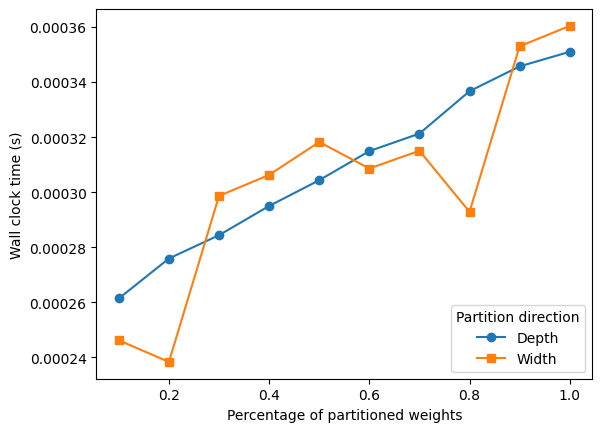

In [5]:
print("Running height partition experiment")
height_results = speed_experiment(height_mlp)
save_data('mnist_height_speed_jit.pkl', height_results)
print("Running width partition experiment")
width_results = speed_experiment(width_mlp)
save_data('mnist_width_speed_jit.pkl', width_results)
partition_exp_plot(height_results, width_results)

We observe that while the total time for the experiment takes longer for the height partitioning, the true update time
remains faster for the width partitioning. This would be due to the JIT compilation used by the jax library simply taking
longer in those cases.

Running height partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:58<00:00, 35.86s/it]


Running width partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [09:37<00:00, 57.75s/it]


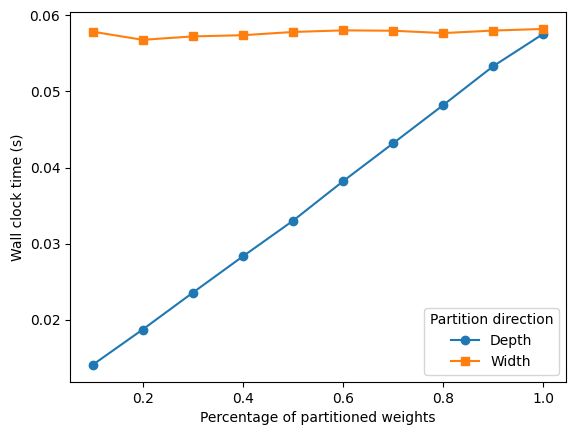

In [6]:
print("Running height partition experiment")
height_results = speed_experiment(height_mlp, jit=False)
save_data('mnist_height_speed_no_jit.pkl', height_results)
print("Running width partition experiment")
width_results = speed_experiment(width_mlp, jit=False)
save_data('mnist_width_speed_no_jit.pkl', width_results)
partition_exp_plot(height_results, width_results)

Now will evaluate the accuracy of the model after 3000 steps of training, with respect to the amount and type of partitioning. We clearly see in the plot
that height partitioning is the most accurate, so models with wider layers but a lower number of layers perform better for this task.

Running height partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:21<00:00, 86.17s/it]


Running width partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [15:07<00:00, 90.77s/it]


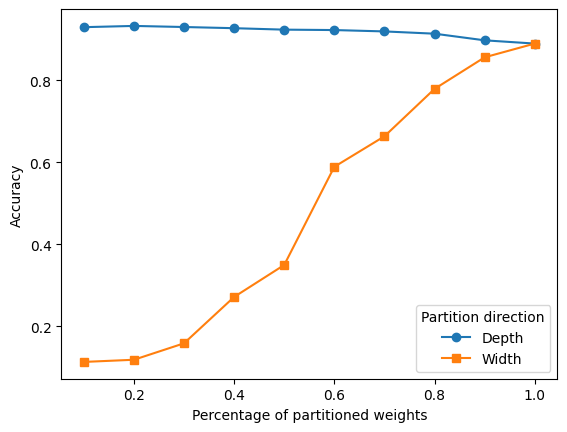

In [7]:
print("Running height partition experiment")
height_results = accuracy_experiment(height_mlp, X, y, train)
save_data('mnist_height_acc_results.pkl', height_results)
print("Running width partition experiment")
width_results = accuracy_experiment(width_mlp, X, y, train)
save_data('mnist_width_acc_results.pkl', width_results)

partition_exp_plot(height_results, width_results, ylabel="Accuracy")

Next, we will see if a similar pattern emerges within a different dataset.

In [4]:
def load_dataset():
    "Load the CIFAR-10 dataset"
    ds = datasets.load_dataset('cifar10')
    ds = ds.map(
        lambda e: {
            'X': np.array(e['img'], dtype=np.float32) / 255,
            'Y': e['label']
        },
        remove_columns=['img', 'label']
    )
    features = ds['train'].features
    features['X'] = datasets.Array3D(shape=(32, 32, 3), dtype='float32')
    ds['train'] = ds['train'].cast(features)
    ds['test'] = ds['test'].cast(features)
    ds.set_format('numpy')
    return ds

ds = load_dataset()
cX, cy = np.concatenate((ds['train']['X'], ds['test']['X'])), np.concatenate((ds['train']['Y'], ds['test']['Y']))
ctrain = np.concatenate((np.repeat(True, len(ds['train'])), np.repeat(False, len(ds['test']))))

Casting the dataset: 100%|█████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 85702.46 examples/s]


Running height partition experiment


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [23:09<00:00, 138.93s/it]


Running width partition experiment


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [34:01<00:00, 204.17s/it]


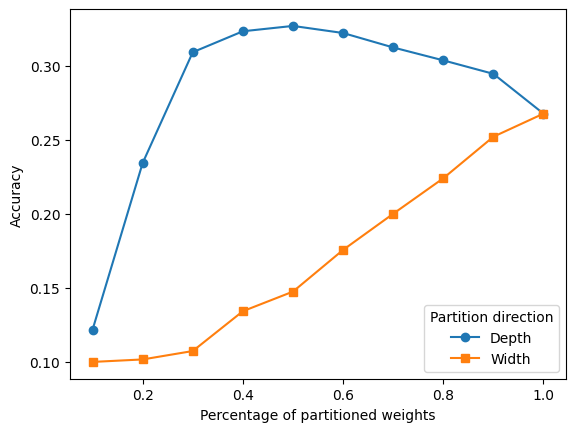

In [8]:
print("Running height partition experiment")
height_results = accuracy_experiment(height_mlp, cX, cy, ctrain)
save_data('cifar10_height_acc_results.pkl', height_results)
print("Running width partition experiment")
width_results = accuracy_experiment(width_mlp, cX, cy, ctrain)
save_data('cifar10_width_acc_results.pkl', width_results)

partition_exp_plot(height_results, width_results, ylabel="Accuracy")

## Convolutional Networks

For convolutional neural networks, we focus on partitioning only the number of channels $p \cdot channels$, since partitioning the kernel would completely change how the layer works.

In [5]:
channels = 100
kernel = (3, 3)


class width_ch_cnn(nn.Module):
    p: float
    channels: int
    layers: int

    @nn.compact
    def __call__(self, x):
        for l in range(self.layers):
            x = nn.Conv(round(self.p * self.channels), kernel)(x)
            x = nn.relu(x)
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        x = nn.Dense(500)(x)
        x = nn.relu(x)
        return nn.softmax(nn.Dense(10)(x))


class height_ch_cnn(nn.Module):
    p: float
    channels: int
    layers: int

    @nn.compact
    def __call__(self, x):
        for l in range(round(self.p * self.layers)):
            x = nn.Conv(self.channels, kernel)(x)
            x = nn.relu(x)
        x = einops.rearrange(x, "b w h c -> b (w h c)")
        x = nn.Dense(500)(x)
        x = nn.relu(x)
        return nn.softmax(nn.Dense(10)(x))

In [10]:
print("Running height partition experiment")
height_ch_results = speed_experiment(height_ch_cnn)
print("Running width partition experiment")
width_ch_results = speed_experiment(width_ch_cnn)

Running height partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [07:20<00:00, 44.00s/it]


Running width partition experiment


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [08:05<00:00, 48.57s/it]


The results from this experiment are somewhat more complicated. While generally height partitioning is faster, the width partitioning
performs better from the 80% partitioning onwards, this appears to be due to the use of 8-10 channels being a better optimized computation.

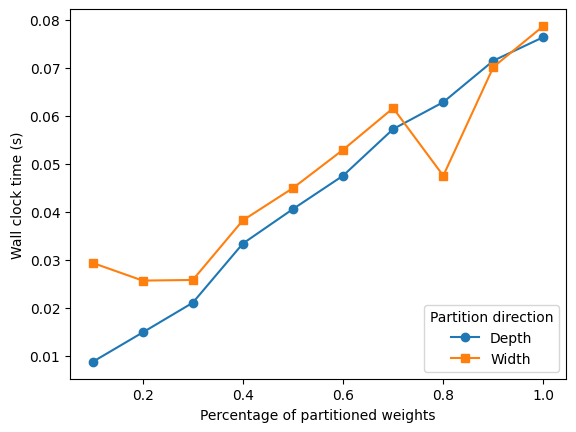

In [11]:
partition_exp_plot(height_ch_results, width_ch_results)

In [ ]:
print("Running height partition experiment")
height_results = accuracy_experiment(height_ch_cnn, X, y, train)
print("Running width partition experiment")
width_results = accuracy_experiment(width_ch_cnn, X, y, train)

partition_exp_plot(height_results, width_results, ylabel="Accuracy")

In [ ]:
print("Running height partition experiment")
height_results = accuracy_experiment(height_ch_cnn, cX, cy, ctrain)
print("Running width partition experiment")
width_results = accuracy_experiment(width_ch_cnn, cX, cy, ctrain)

partition_exp_plot(height_results, width_results, ylabel="Accuracy")

# Comparing Partitioning by Hyperparameters to Parameters

In the CNN experiments, we see that both width and height partitioning appears equivalent with respect to the amount
of partitioning of the hyperparameters, channels and kernel shape. The linear network experiments differ in this
sense, where the partitioning of hyperparameters is more beneficial to computation time when performed across the
width. In the following we will mathematically and empirically show that the conflicting properties of the linear
network is a result of the difference in the number of parameters arising from the hyperparameter based 
partitioning.

## Direct Proofs

We will first define the number of hyperparameters as $H$, and the number of parameters as $P$, we also use $p$ to
indicate the percent of (hyper)parameters that are being partitioned.

In linear networks the number of hyperparameters is the number of neurons and is equal to the product of the number
of layers, $L$, and the number of neurons in each layer, $W$. So in this case,

\begin{equation}
    H = LW
\end{equation}

Then if we take the partition by depth, we would set the number of layers to $L = pL_{max}$, where $L_{max}$ is the
full networks' number of layers. This will give the following number of hyperparameters, where
$H_{max} = L_{max} W_{max}$ is the full network we are partioning,

\begin{equation}
    H = (pL_{max})W_{max} = pH_{max}
\end{equation}

If also look at taking the partition by width, we would set the width of the layers to $W = pW_{max}$ where 
$W_{max}$ is full networks' width per layer. The result is as follows,

\begin{equation}
    H = L_{max} (pW_{max}) = pH_{max}
\end{equation}

As expected, both partitioning strategies take equal partitions of the hyperparameters, however, this is not true
for the parameters.

In a linear network the number parameters with respect to the width and height of the network are as follows,

\begin{equation}
    P = LWW
\end{equation}

Now if we take the same partition of the depth of the network, where $P_{max} = L_{max} W_{max} W_{max}$,

\begin{equation}
     P = (pL_{max})W_{max}W_{max} = pP_{max}
\end{equation}

The result is as expected, however, when take the partition by the width we find that the partitioning amount 
appears twice due to the number of parameters being equal to the product of the number of neurons in the current
layer and the number of neurons in the next layer.

\begin{equation}
    P = L_{max} (pW_{max})(pW_{max}) = p^2 P_{max}
\end{equation}

Hence, the number of parameters follow a quadratic partitioning amount when taken by width while following a linear
amount when taken by the height. In the following, using this observation we will show that the computation time of
the neural network updates is directly proportional to the number of parameters by setting $p = \sqrt{p}$ for only
the width based experiments.

## Empirical Proof

In [ ]:
print("Running height partition experiment")
height_results = speed_experiment(height_mlp)
print("Running width partition experiment")
width_results = speed_experiment(width_mlp, p_pipeline=[math.sqrt])

partition_exp_plot(height_results, width_results)